In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import networkx as nx
from tqdm import trange
from fairness_goodness_computation import *
import csv 

Data = open('soc-sign-bitcoinotc.csv', "r")
next(Data, None)  # skip the first line in the input file
Graphtype = nx.DiGraph()

G = nx.parse_edgelist(Data, delimiter=',', create_using=Graphtype, nodetype=int, data=(('Weight', int),('Timestamp', int)))

# Setting weights -1 to 1
weights = nx.get_edge_attributes(G,"Weight")
for key, val in weights.items():
    weights[key] = val/10
nx.set_edge_attributes(G, weights, "Weight")

In [2]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 5881
Number of edges: 35592
Average in degree:   6.0520
Average out degree:   6.0520


In [167]:
[len(c) for c in sorted(nx.connected_components(G.to_undirected()), key=len, reverse=True)]

[5875, 2, 2, 2]

In [188]:
nodes = []
WW = nx.get_edge_attributes(G,"Weight")
count = 0
for i in (G.edges):
    if(WW[i] < 0):
        nodes.append(i[0])
        nodes.append(i[1])
        count+=2
    if(count == 400):
        break    

In [258]:
H = G.to_undirected().subgraph(nodes)
nx.info(H)

'Name: \nType: Graph\nNumber of nodes: 177\nNumber of edges: 701\nAverage degree:   7.9209'

In [259]:
np.unique((np.array(list(nx.get_edge_attributes(H,"Weight").values()) ) > 0).astype(int), return_counts = 1)

(array([0, 1]), array([244, 457], dtype=int64))

In [260]:
A = nx.adjacency_matrix(H, weight = "Weight")

In [261]:
print('Adjacency matrix:')
A.todense()

Adjacency matrix:


matrix([[0. , 0.8, 0.6, ..., 0. , 0. , 0.7],
        [0.8, 0. , 0.8, ..., 0. , 0. , 0. ],
        [0.6, 0.8, 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0.7, 0. , 0. , ..., 0. , 0. , 0. ]])

In [262]:
D = np.diag(np.sum(np.abs(np.array(A.todense())), axis=1))
print('Degree matrix:')
print(D)

Degree matrix:
[[24.8  0.   0.  ...  0.   0.   0. ]
 [ 0.   7.3  0.  ...  0.   0.   0. ]
 [ 0.   0.   5.4 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  1.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.2  0. ]
 [ 0.   0.   0.  ...  0.   0.  20.5]]


In [263]:
L = D - A
L

matrix([[24.8, -0.8, -0.6, ...,  0. ,  0. , -0.7],
        [-0.8,  7.3, -0.8, ...,  0. ,  0. ,  0. ],
        [-0.6, -0.8,  5.4, ...,  0. ,  0. ,  0. ],
        ...,
        [ 0. ,  0. ,  0. , ...,  1. ,  0. ,  0. ],
        [ 0. ,  0. ,  0. , ...,  0. ,  0.2,  0. ],
        [-0.7,  0. ,  0. , ...,  0. ,  0. , 20.5]])

In [264]:
e, v = np.linalg.eig(L)
mapp = dict(zip(e,v))
SMALLEST = mapp[min(e[e > 0])]

In [265]:
from sklearn.cluster import SpectralClustering, KMeans
i = np.where(e < 0.5)[0]
U = np.array(np.real(SMALLEST.T))
print(U.shape)
km = KMeans(init='k-means++', n_clusters=19)
km.fit(U)
km.labels_

(177, 1)


array([ 0,  4,  4, 12,  7, 15,  0,  0,  8, 15,  7, 15, 15, 13,  9,  7,  0,
       15,  7,  7,  0,  7,  9,  0,  9,  7,  0, 16, 15, 15,  7, 16,  9, 16,
        7,  7, 16, 12, 16, 13,  9,  0,  0, 17,  6, 12, 11,  7, 17, 13, 18,
       11, 13,  4,  4,  1,  2, 11,  8,  0,  0,  3,  6,  4,  7,  5,  3, 13,
       11,  4, 14, 11, 15, 13,  0,  6, 18, 14,  9, 16, 10, 15, 12,  4,  7,
        9,  7, 15,  9, 13,  9,  4,  0,  7,  0, 12, 15, 16,  7,  0,  0,  0,
       15,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15, 15,  0,  9, 16,  0,  9,
       12,  9, 16,  0, 16, 12,  0,  0,  0,  9,  4, 18, 13,  0, 16, 15, 16,
        0, 15, 15,  9, 16, 16, 12,  7,  0, 13, 15,  7, 15, 15,  7, 17,  7,
       15, 11,  9, 16,  0, 15, 16,  0,  0,  9, 16,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [266]:
from collections import defaultdict
dic = defaultdict(list)
for i in range(len(list(H.nodes))):
    dic[km.labels_[i]].append(list(H.nodes)[i])

In [267]:
import numpy as np
pos = nx.circular_layout(H)
r = 7
radii = list(range(r*1, r*len(dic.keys()) + r, r))

for ea in pos.keys():
    new_r = 1
    for i in range(len(dic.keys())):
        if(ea in dic[i]):
            new_r = radii[i]
    pos[ea] *= new_r

In [268]:
colos = list((np.array(list(nx.get_edge_attributes(H,"Weight").values()) ) > 0).astype(int))

In [269]:
# --- Begin_myhack ---
# All this code should replace original `pos=nx.spring_layout(graph)`
import numpy as np
pos = nx.circular_layout(H)   # replaces your original pos=...
# prep center points (along circle perimeter) for the clusters
angs = np.linspace(0, 2*np.pi, 1+len(dic.keys()))
repos = []
rad = 3.5     # radius of circle
for ea in angs:
    if ea > 0:
        #print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
for ea in pos.keys():
    posx = 0
    for i in range(len(dic.keys())):
        if(ea in dic[i]):
            posx = i
    #print(ea, pos[ea], pos[ea]+repos[posx], color, posx)
    pos[ea] += repos[posx]
# --- End_myhack ---

{1: Text(4.310360345952221, 1.1364481381333056, '0'),
 2: Text(0.7103422697510973, 3.5235364876340425, '4'),
 3: Text(0.7084531005335495, 3.5589825354430515, '4'),
 4: Text(-0.41159916935688945, -3.0989131627288913, '12'),
 6: Text(-2.0882221946865154, 1.8073320952007605, '7'),
 2566: Text(2.8986083187748917, -2.7535220226356314, '15'),
 7: Text(4.287763748264067, 1.347830765776201, '0'),
 1543: Text(4.2796458340582575, 1.3823863946974155, '0'),
 13: Text(-2.492318227577003, 0.8562650330340693, '8'),
 17: Text(2.8637161769301884, -2.6160059561023323, '15'),
 2065: Text(-2.140505481773369, 2.0133895693696937, '7'),
 19: Text(2.839044860765164, -2.5494499493833063, '15'),
 2581: Text(2.82495330945092, -2.5168704975599145, '15'),
 25: Text(0.6063681657468918, -3.042774743913513, '13'),
 26: Text(-2.5732358244536275, -0.09931230784120287, '9'),
 35: Text(-2.2166040431163525, 2.173481684889846, '7'),
 1572: Text(4.153354201312943, 1.6743712957446792, '0'),
 39: Text(2.7376900232728993, -2.3

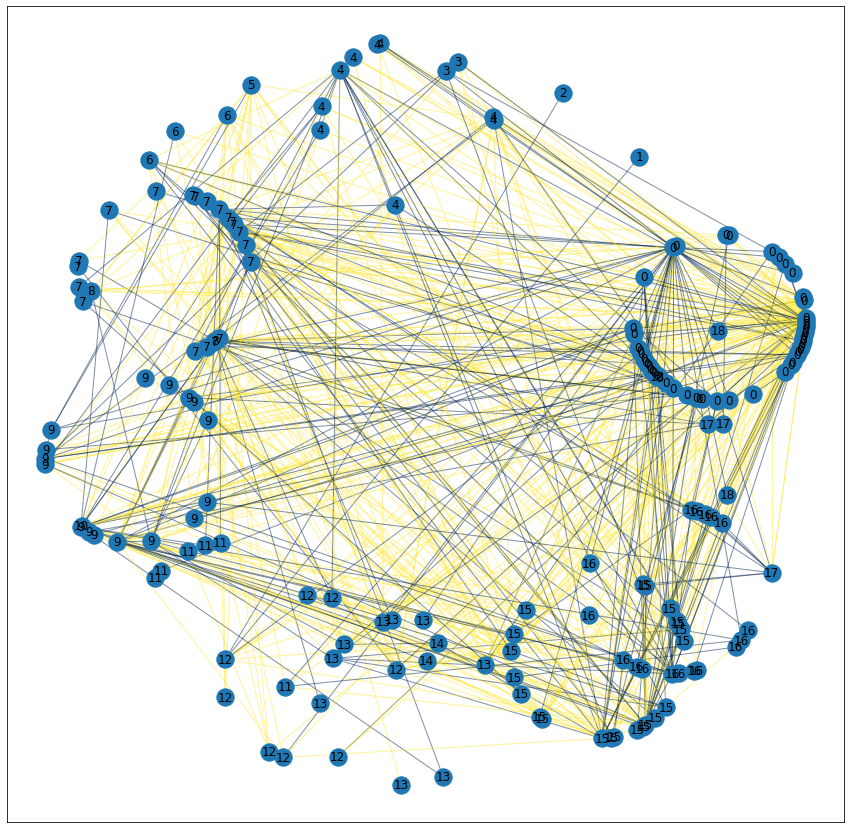

In [279]:
plt.figure(figsize = (15,15))
# plt.xlim(-(r*len(dic.keys()) + r),r*len(dic.keys()) + r + 10)
# plt.ylim(-(r*len(dic.keys()) + r),r*len(dic.keys()) + r + 10)
nx.draw_networkx_nodes(H, pos = pos)
nx.draw_networkx_edges(H, pos = pos, width=1.0, alpha=0.5, edge_color = colos, edge_cmap = plt.cm.cividis)
nx.draw_networkx_labels(H, labels = dict(zip(list(H.nodes), km.labels_)), pos = pos)